# Análisis de la medida de retardancia y localización del eje rápido 

**Author**: Joaquín Andrés Porras

**Date**:   28/06/2023

**Motivation**: Proyecto TELURO

**Objective**:

En este archivo, se procede a realizar el análisis de las medidas experimentales obtenidas para obtener la retardancia y la localización del eje rápido de un retardador

## <center>Carga de módulos y variables</center>

In [1]:
# Autorreload
%load_ext autoreload
%autoreload 2 

In [2]:
# MÓDULOS ANÁLISIS DE DATOS Y REPRESENTACIÓN GRÁFICA
import numpy as np                                                      # Cálculo numérico
import matplotlib.pyplot as plt                                         # Representación gráfica Matplotlib
import time                                                             # Tiempo
import imageio                                                          # Creación de archivos gif
from py_pol.mueller import Mueller, degrees, create_Mueller, Stokes     # Análisis de matrices de Mueller
from glob import glob                                                   # Para listar imágenes
import os                                                               # Gestión de archivos
import scipy                                                            # Cálculo científico
from scipy.signal import find_peaks                                     # Scipy - encontrar mínimos
from matplotlib import rcParams


In [3]:
rcParams['figure.dpi'] = 150  #dpi
rcParams['axes.linewidth'] = 1.5
rcParams['axes.formatter.useoffset'] = False
rcParams['font.size'] = 14
rcParams['axes.labelsize'] = 14

# <center>Obtención de imágenes</center>


In [4]:
ruta = os.getcwd()

In [137]:
# Parámetros: 
filename = 'Plastico_90_azul_90g_03_07_23'

# Nombres de los archivos
filename_gif = filename + '.gif'
filename_npz = filename + '.npz'
filename_jpg = filename + '.jpg'
filename_png = filename + '.png'

# Calculo sencillo

In [6]:
os.chdir(ruta+"\Results")
a = np.load("Results_{}".format(filename_npz))
os.chdir(ruta)

In [82]:
error_acimut = [6,0,3,6,6]
np.sqrt(np.sum(np.square(error_acimut)))/np.sqrt(len(error_acimut))

4.83735464897913

array([ 84, 264, 276, 306, 444, 630, 720], dtype=int64)

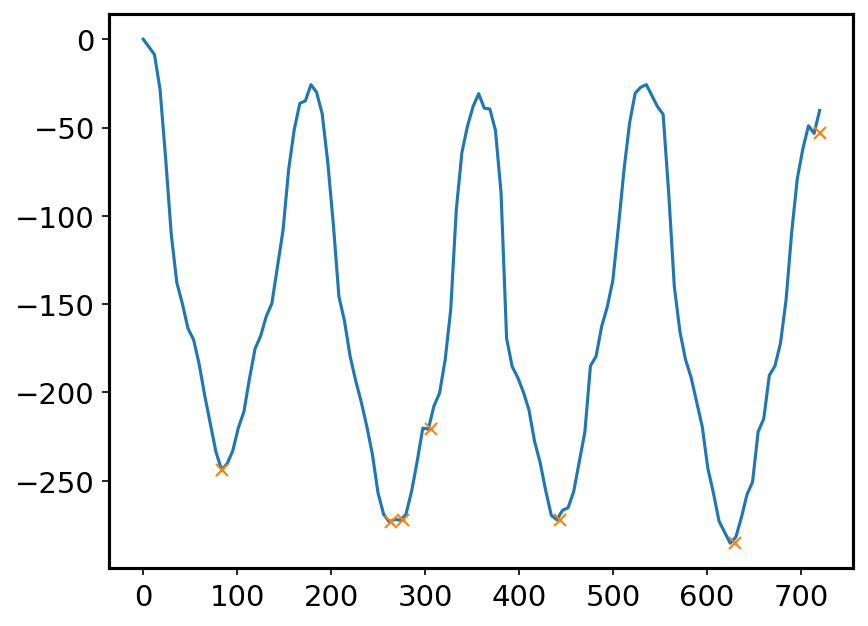

In [80]:
phase = a['Phi']

# minimos
peaks, _ = find_peaks(-phase)
plt.figure()
plt.plot(np.linspace(0,720,122),phase)
plt.plot(6*peaks, phase[peaks], "x")

# primer minimo
6*peaks

La retardancia - método clasico - es de: 
118.29857142857145


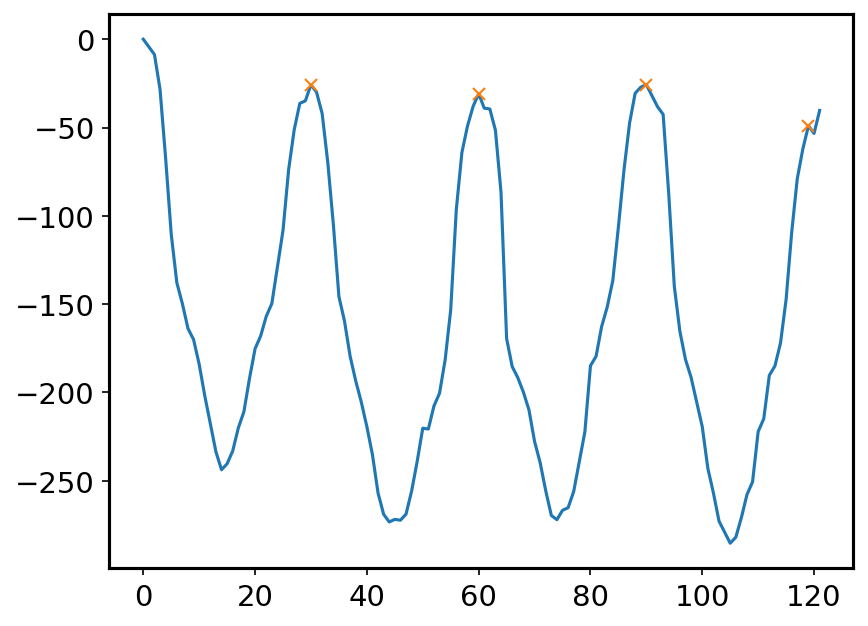

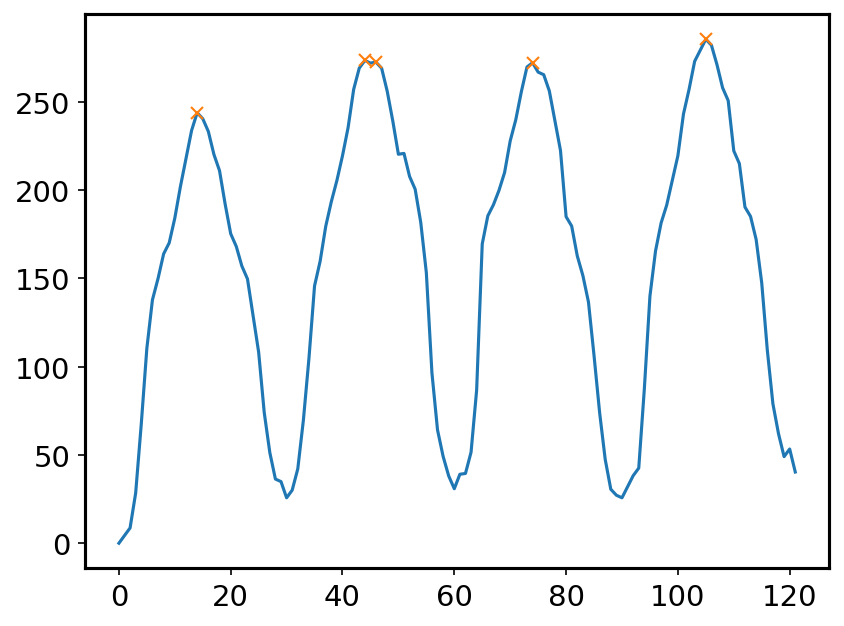

In [92]:
# maximos
peaks, _ = find_peaks(phase, height = -50)
phase_max = np.mean(phase[peaks])
plt.plot(phase)
plt.plot(peaks, phase[peaks], "x")

# minimos
peaks, _ = find_peaks(-phase, height = 230)
phase_min = np.mean(phase[peaks])
plt.figure()
plt.plot(-phase)
plt.plot(peaks, -phase[peaks], "x")

# retardancia
retardance = (phase_max-phase_min)/2
print("La retardancia - método clasico - es de: ")
print(retardance)

# Análisis no lineal

In [138]:
# Obtención de los resultados experimentales
os.chdir(ruta + "\Data")
imagenes = np.load(filename_npz)["imagenes"]

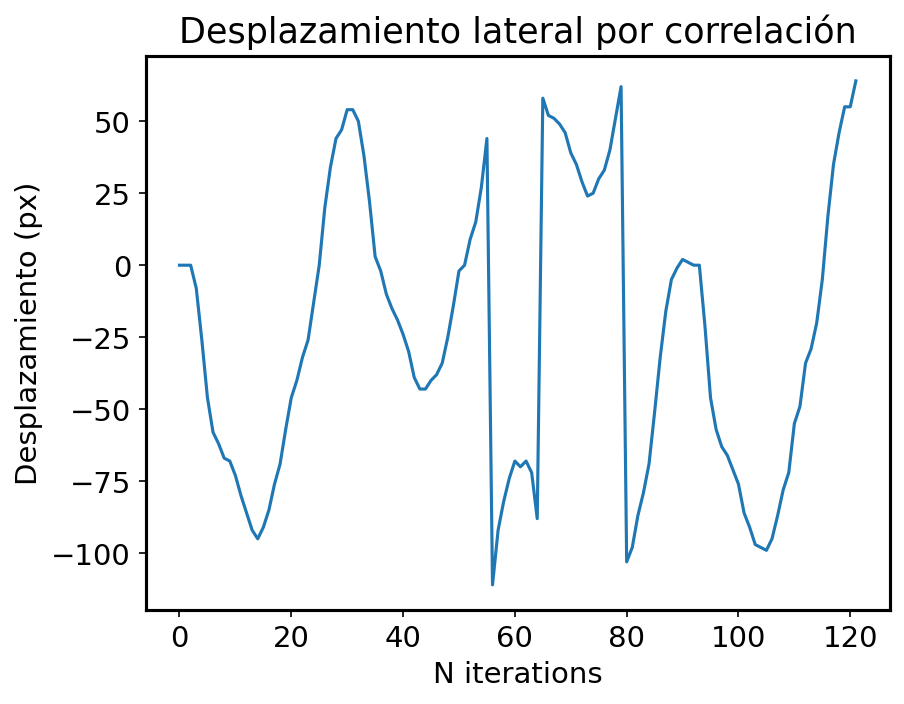

In [142]:
# Obtención de la gráfica del desplazamiento lateral
n = imagenes.shape[0]
angle_end = 720
angles = np.linspace(0,angle_end,n)
dist_x = np.zeros(n)

for i,angle in enumerate(angles):
    dist_x[i] = np.correlate(imagenes[0,:],imagenes[i,:],mode = "same").argmax() - imagenes[0,:].size/2
plt.plot(dist_x)
plt.xlabel("N iterations")
plt.ylabel("Desplazamiento (px)")
plt.title("Desplazamiento lateral por correlación")
os.chdir(ruta+"\Images")
plt.savefig(filename_jpg)

In [87]:
#Creación de imágenes
os.chdir(ruta+"\Images")
for i in range(imagenes.shape[0]): 
    plt.figure()
    plt.plot(imagenes[i,:])
    plt.savefig("{}.png".format(i))
    plt.close()
    print(i, end="\r")
print("Terminado.", end="\r")

# Creación de GIF
filenames = sorted(list(glob("*.png")))
imgs = []
for f in filenames:
    imgs.append(imageio.imread(f))


imageio.mimsave(filename_gif, imgs, duration=0.5, subrectangles=True)

# Eliminación archivos temporales
for j in range(n): 
    os.remove(filenames[j])

# Cierre de gestión de archivos
os.chdir(ruta)


## <center>Ajuste del desplazamiento de la fase</center>

In [143]:
# Obtención del desplazamiento por longitudes de onda
minimums = np.correlate(imagenes[0,:], imagenes[0,:], mode = "same") - imagenes[0,:].size/2
period = np.mean(np.diff(scipy.signal.find_peaks(minimums)[0]))

Phi_exp_lambda = np.unwrap(dist_x,period = period)/period
# Phi_exp_lambda = Phi_exp_lambda[1:]

Text(0.5, 1.0, 'Desplazamiento lateral por correlación')

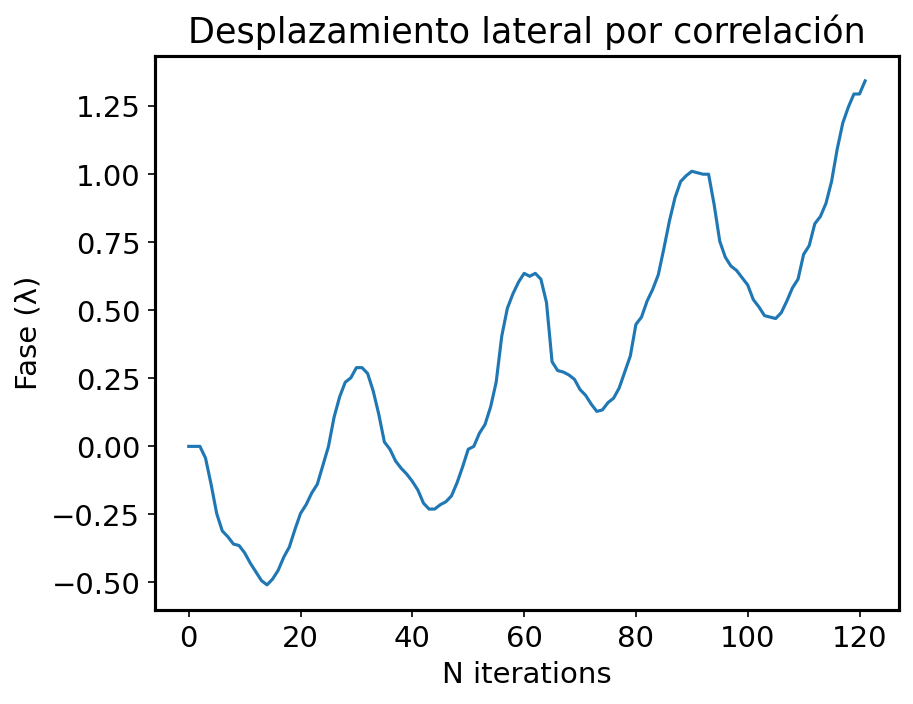

In [144]:
# Representación gráfica del desplazamiento en función de la longitud de onda
plt.plot(Phi_exp_lambda)
plt.xlabel("N iterations")
plt.ylabel("Fase (λ)")
plt.title("Desplazamiento lateral por correlación")

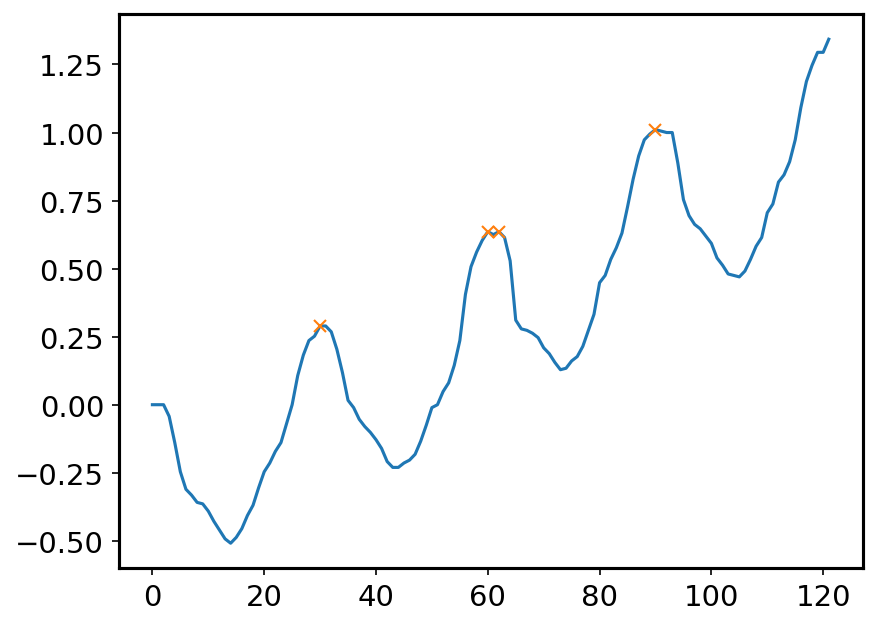

In [145]:
# En caso de ser necesario, corregir los desplazamientos por tiempo: 
peaks, _ = find_peaks(Phi_exp_lambda)
plt.plot(Phi_exp_lambda)
plt.plot(peaks, Phi_exp_lambda[peaks], "x")

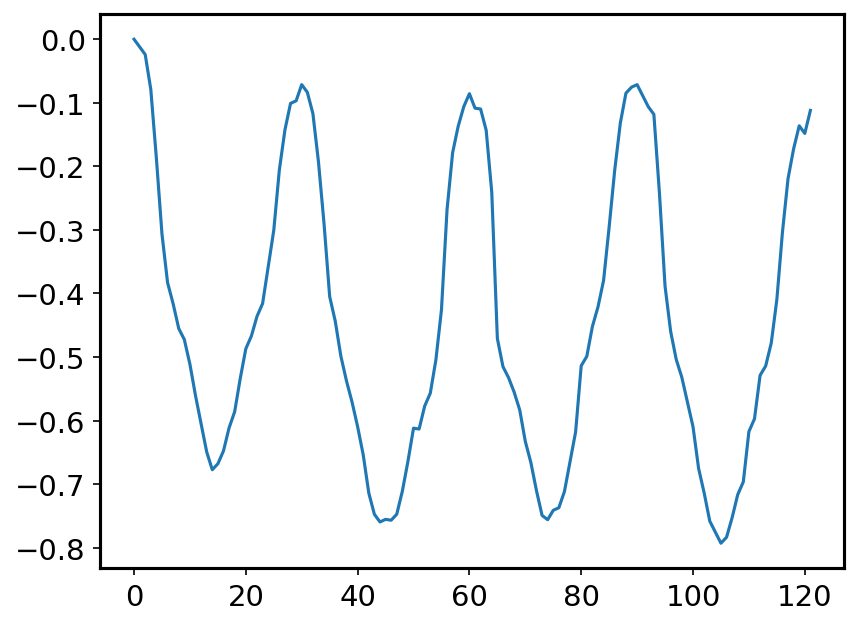

In [146]:
# Obtención de ajuste lineal por máximos
puntos_ajuste = [0,-1]

slope = (Phi_exp_lambda[peaks[puntos_ajuste[1]]]-Phi_exp_lambda[peaks[puntos_ajuste[0]]])/((peaks[puntos_ajuste[1]])-(peaks[puntos_ajuste[0]]))
dist_y = Phi_exp_lambda - np.arange(n)*slope
plt.plot(dist_y)
Phi_exp_lambda = dist_y

In [147]:
# Paso de longitud de onda a grados y a radianes
Phi_exp = 2*np.pi * Phi_exp_lambda          # Radianes
Phi_exp_deg = Phi_exp / degrees       # Gra>dos


In [148]:
# Eje X de grados (OJO si no se toman todos los datos de desplazamiento)
x = np.linspace(0,720 * degrees, n)

In [152]:
def remove_values_in_range(x_values, y_values, min_value, max_value):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    mask = np.logical_not(np.logical_and(y_values > min_value, y_values < max_value))
    
    filtered_x = x_values[mask]
    filtered_y = y_values[mask]
    return filtered_x, filtered_y


# Paso de longitud de onda a grados y a radianes
Phi_exp = 2*np.pi * Phi_exp_lambda          # Radianes
Phi_exp_deg = Phi_exp / degrees       # Gra>dos

# Eje X de grados (OJO si no se toman todos los datos de desplazamiento)
x = np.linspace(0,720 * degrees, n) 


percentage = [25,75]
g = [5,5]
x, Phi_exp = remove_values_in_range(x, Phi_exp, Phi_exp.min()+(percentage[0]/100)*(Phi_exp.max()-Phi_exp.min()), Phi_exp.min()+(percentage[1]/100)*(Phi_exp.max()-Phi_exp.min()))

if g[1] is not 0:
    x = x[g[0]:-g[1]]
    Phi_exp = Phi_exp[g[0]:-g[1]]

In [153]:
# Definiciones para ajuste por mínimos cuadrados

def model_period(par, x):
    Fase  = -np.arctan2((np.sin(par[0])*np.cos(2*(x-par[1]))),(np.cos(par[0])*np.cos(2*(x-par[1]))**2 + np.sin(2*(x-par[1]))**2)) + par[2]
    return Fase


def error_period(par, x, Fase_exp):
    """Function that serves as optimization for cos**2."""
    Fase = model_period(par, x)
    dif = Fase_exp - Fase
    return dif

bounds = ([0*degrees, -180*degrees, -360*degrees], [180*degrees, 180*degrees, 360*degrees])        # Límites
par0 = [90*degrees, np.random.rand()*180*degrees, Phi_exp[0]]                                   # Valores iniciales de los parámetros
result = scipy.optimize.least_squares(error_period, par0, args=(x, Phi_exp), bounds=bounds)     # Mínimos cuadrados
par1 = result.x                                                                                 # Resultado

# CÁCULO DE ERRORES EN EL AJUSTE
sigma = np.linalg.inv(np.dot(result.jac.T , result.jac))
error_ret = np.sqrt(sigma[0,0])/degrees
error_eje_opt = np.sqrt(sigma[1,1])/degrees
error_fase_ini = np.sqrt(sigma[2,2])/degrees

# Imprimimos el resultado obtenido de los parámetros del ajuste
print("Retardancia: {:.2f} ".format(par1[0]/degrees) + u"\u00B1" + " {:.2f}".format(error_ret) + "\n")
print("Eje óptico: {:.2f} ".format(par1[1]/degrees) + u"\u00B1" + " {:.2f}".format(error_eje_opt) + "\n")
print("Fase inicial: {:.2f} ".format(par1[2]/degrees) + u"\u00B1" + " {:.2f}".format(error_fase_ini) + "\n")

Retardancia: 120.93 ± 8.68

Eje óptico: 86.18 ± 2.51

Fase inicial: -155.97 ± 7.47



In [154]:
np.sqrt(np.abs(sigma))/degrees

array([[8.67641937, 0.68207352, 2.96782589],
       [0.68207352, 2.50709402, 0.77392293],
       [2.96782589, 0.77392293, 7.46935019]])

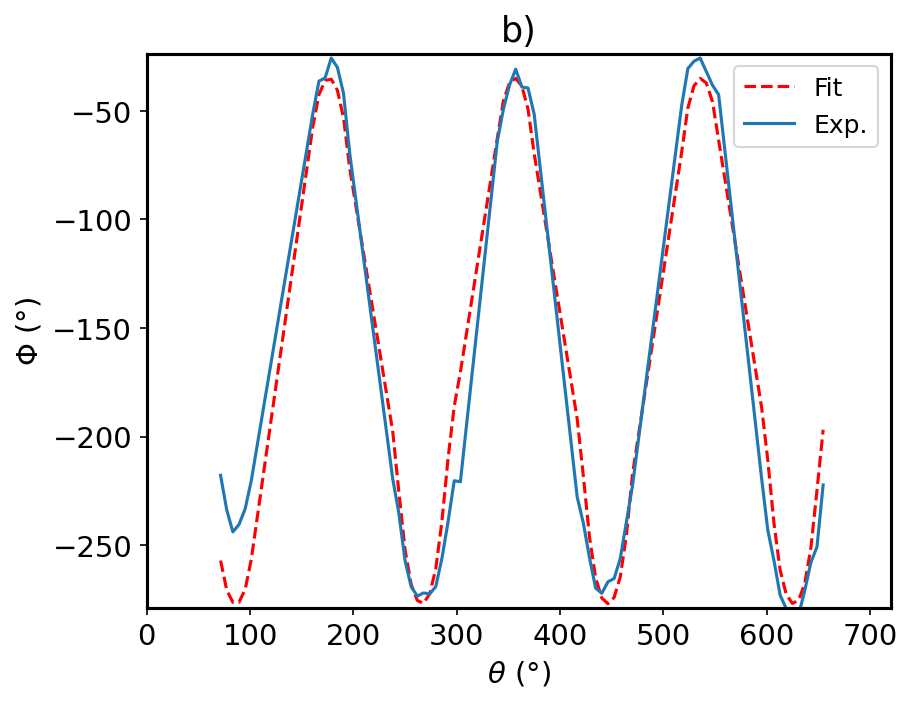

In [155]:
# Gráfica del desplazamiento y ajuste en grados: 
plt.plot(x / degrees, model_period(par1,x) / degrees, "r--", label = "Fit")
plt.plot(x / degrees,Phi_exp / degrees, label="Exp.")
plt.ylabel("$\Phi$ (°)")
plt.xlabel("$\\theta$ (°)")

#plt.text(0,(Phi_exp.max()/degrees)+2,texto_ret+texto_eje+texto_fase)
plt.title("b)")
plt.legend(loc = "upper right", fontsize=12)
#plt.xlim([np.min(x / degrees),np.max(x / degrees)])
#plt.xlim([np.min(x / degrees),np.max(x / degrees)])
plt.xlim([0,720])
#plt.ylim([np.min(Phi_exp / degrees),np.max(Phi_exp / degrees)])
plt.ylim([np.min(model_period(par1,x) / degrees)-2,np.max(Phi_exp / degrees)+2])
os.chdir(ruta+"\Results")
plt.savefig(filename_png)
os.chdir(ruta)

In [43]:
os.chdir(ruta+"\Results")
np.savez(file = "Results_{}".format(filename_npz), ret = np.around(par1[0]/degrees,2), error_ret = np.around(error_ret,2), eje_optico = np.around(par1[1]/degrees,2), error_eje_optico = np.around(error_eje_opt,2), fase_inicial = np.around(par1[2]/degrees,2), error_fase_inicial = np.around(error_fase_ini,2), Phi = Phi_exp/degrees, Phi_ajuste = model_period(par1,x) / degrees, x = x)
os.chdir(ruta)


In [44]:
#Comprobación de existencia del archivo
os.chdir(ruta+"\Results")
a = np.load("Results_{}".format(filename_npz))
os.chdir(ruta)

In [45]:
a['error_ret']


array(11.29)